In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [31]:
# Load dataset
df = pd.read_csv("creditcard.csv")  # Ensure the file is in the same directory as your script

In [35]:
# Data exploration
print(df.head())
print(df.info())
print(df.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [37]:
# Handling class imbalance
print("Class Distribution:")
print(df['Class'].value_counts())

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [39]:
# Splitting data
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [43]:
# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [45]:
# ---------------------- Isolation Forest Model ----------------------
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_forest.fit(X_train_scaled)
y_pred_if = iso_forest.predict(X_test_scaled)
y_pred_if = np.where(y_pred_if == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

print("\nIsolation Forest Classification Report:")
print(classification_report(y_test, y_pred_if))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_if))


Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.04      0.28      0.07        98

    accuracy                           0.99     56962
   macro avg       0.52      0.63      0.53     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC Score: 0.6325145280396909


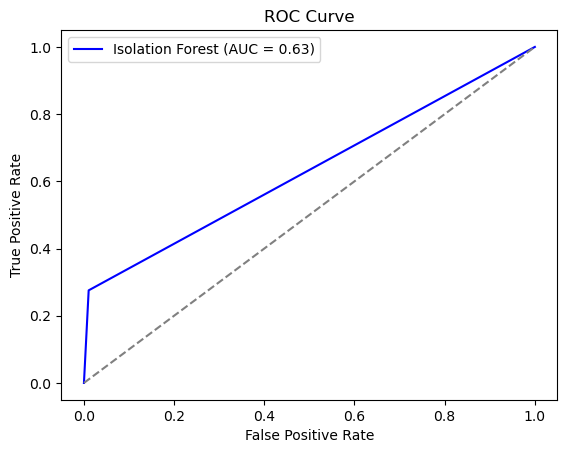

In [47]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_if)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='Isolation Forest (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [49]:
# ---------------------- Autoencoder Model ----------------------
def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(32, activation='relu')(input_layer)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(16, activation='relu')(encoded)
    encoded = layers.Dense(8, activation='relu')(encoded)
    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(32, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)
    autoencoder = keras.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [51]:
# Train autoencoder
input_dim = X_train_scaled.shape[1]
autoencoder = build_autoencoder(input_dim)
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test_scaled, X_test_scaled))

Epoch 1/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.9014 - val_loss: 0.3742
Epoch 2/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7805 - val_loss: 0.3610
Epoch 3/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7687 - val_loss: 0.3557
Epoch 4/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7585 - val_loss: 0.3534
Epoch 5/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7533 - val_loss: 0.3521
Epoch 6/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7508 - val_loss: 0.3512
Epoch 7/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7485 - val_loss: 0.3506
Epoch 8/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7517 - val_loss: 0.3500
Epoch 9/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7481 - val_loss: 0.3499
Epoch 10/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7490 - val_loss: 0.3495
Epoch 11/50
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7530 - val_loss: 0.3491
Epoch 12/50
1777/1777 ━━━━━━━

In [53]:
# Calculate reconstruction errors
X_test_reconstructed = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.abs(X_test_scaled - X_test_reconstructed), axis=1)
threshold = np.percentile(reconstruction_error, 98)  # Define threshold


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [55]:
# Predict anomalies
y_pred_ae = np.where(reconstruction_error > threshold, 1, 0)

print("\nAutoencoder Classification Report:")
print(classification_report(y_test, y_pred_ae))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_ae))


Autoencoder Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.03      0.36      0.06        98

    accuracy                           0.98     56962
   macro avg       0.51      0.67      0.52     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC Score: 0.6688552636867916


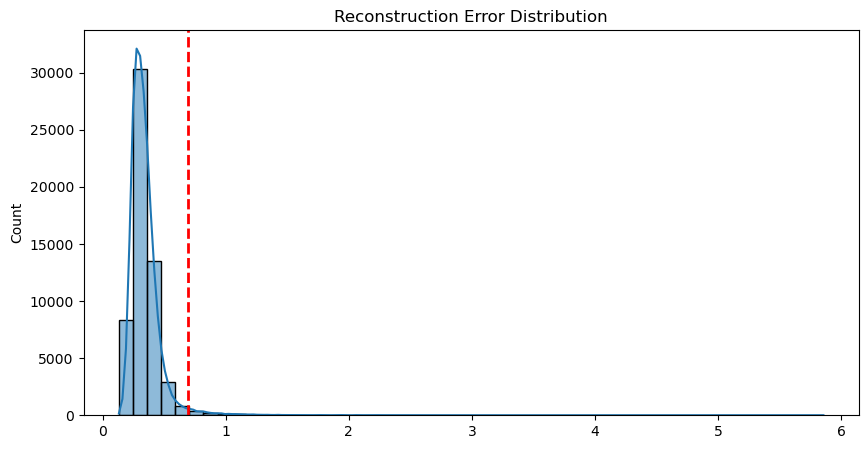

In [57]:
# Visualization - Reconstruction Error Distribution
plt.figure(figsize=(10, 5))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.title("Reconstruction Error Distribution")
plt.show()



In [62]:
!pip install ipywidgets

In [76]:
# Ensure StandardScaler is correctly assigned
trained_scaler = StandardScaler()
X_scaled = trained_scaler.fit_transform(X)  # Fit on full dataset

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train Isolation Forest
trained_iforest = IsolationForest(contamination='auto', random_state=42)
trained_iforest.fit(X_train)

# Train Autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

trained_autoencoder = Model(input_layer, decoded)
trained_autoencoder.compile(optimizer='adam', loss='mse')
trained_autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Compute Reconstruction Error
train_predictions = trained_autoencoder.predict(X_train)
train_errors = np.mean(np.abs(train_predictions - X_train), axis=1)
autoencoder_threshold = np.mean(train_errors) + 2 * np.std(train_errors)


Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.9265 - val_loss: 0.8516
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.8211 - val_loss: 0.8305
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.8414 - val_loss: 0.8156
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.8039 - val_loss: 0.8053
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.8040 - val_loss: 0.7988
Epoch 6/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7949 - val_loss: 0.7884
Epoch 7/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7797 - val_loss: 0.7817
Epoch 8/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.7627 - val_loss: 0.7778
Epoch 9/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.7600 - val_loss: 0.7743
Epoch 10/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7611 - val_loss: 0.7703
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


In [78]:
# Example usage (assuming models are trained and available)
test_user_input_fixed(trained_iforest, trained_autoencoder, trained_scaler, autoencoder_threshold)



Testing with a predefined transaction sample...


C:\Users\nikhi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

=== Model Predictions ===
Isolation Forest: Normal Transaction
Autoencoder: Anomalous Transaction (Fraud)

⚠️ Fraudulent Transaction Detected! ⚠️
